# Catmull-Rom Analysis
This Notebook contains all the analysis made directly on the Catmull-Rom CSV file.

## Libraries

In [129]:
library(tidyverse)
library(DT) # dependency
library(ggthemes) # dependency

data <- read_csv("catmull-rom-dataset.csv")

Warning message:
"Missing column names filled in: 'X1492' [1492]"Warning message:
"Duplicated column names deduplicated: 'datetime' => 'datetime_1' [6]"Parsed with column specification:
cols(
  .default = col_double(),
  userId = col_character(),
  age = col_character(),
  datetime = col_character(),
  gender = col_character(),
  datetime_1 = col_character(),
  stage = col_integer(),
  condition = col_character(),
  subcondition = col_integer(),
  pageIndex = col_integer(),
  noiseIndex = col_integer(),
  day0 = col_character(),
  day1 = col_character(),
  day2 = col_character(),
  day3 = col_character(),
  day4 = col_character(),
  day5 = col_character(),
  day6 = col_character(),
  day7 = col_character(),
  day8 = col_character(),
  day9 = col_character()
  # ... with 70 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"1452 parsing fai

In [130]:
# Source: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/

# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [275]:
#source: https://stackoverflow.com/questions/6364783/capitalize-the-first-letter-of-both-words-in-a-two-word-string
simple_cap <- function(x) {
    x <- gsub("_", " ", x)
    
    s <- strsplit(x, " ")[[1]]
  
    paste(toupper(substring(s, 1,1)), substring(s, 2),
      sep="", collapse=" ")
}

## Universal functions and variables

In [234]:
conditions = c('temperature', 'rain', 'sales', 'gym_memberships', 'wage', 'facebook_friends')
subconditions = c(1, 2, 3)

In [152]:
get_range <- function(condition){
    
    range_array <- switch(
            condition,
            temperature = c(-10, 40),
            sales = c(0, 5000),
            facebook_friends = c(0, 1000),
            rain = c(0, 100),
            gym_memberships = c(0, 50),
            wage = c(0, 50)
        )
    
    range_value <- range_array[2] - range_array[1]
    
    delta <- range_value / 10
    
    c(range_array[1] - delta, range_array[2] + delta)

}

In [276]:
get_title <- function(condition_name, stage_number, subcondition_value=0) {
    if(stage_number == 1) {
        return(simple_cap(condition_name))
    }
    else {
        if(subcondition_value == 1){
            return('Positive slope')
        }
        else if(subcondition_value == 2){
            return('Neutral slope')
        }
        else {
            return('Negative slope')
        }
    }
}

## Preparing the data

Transform the day columns to two columns: day and value

In [133]:
tidy_data <- data %>% 
    gather(day, value, starts_with("day"))

Column transformations:

In [134]:
tidy_data$day <- as.numeric(gsub("day", "", tidy_data$day));
tidy_data$value <- as.numeric(tidy_data$value);

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

## Random data stuff

In [209]:
tidy_data$userId %>%
    unique %>%
    length

[1] 121

In [225]:
for(c in conditions) {
    for (sc in c(1,2,3)) {
        count <- (tidy_data %>%
        filter(stage == 2,
               condition == c,
               subcondition == sc))$userId %>%
        unique %>%
        length
    
        print(count)
    }
}

[1] 48
[1] 38
[1] 35
[1] 39
[1] 40
[1] 42
[1] 39
[1] 47
[1] 35
[1] 36
[1] 39
[1] 46
[1] 35
[1] 44
[1] 42
[1] 45
[1] 34
[1] 42


## Plot

Plot function

In [356]:
plot_variable <- function(condition_name, stage_number, subcondition_value=0) {
    
    # Data filtering 
    filtered_data <- tidy_data %>%
        filter(stage == stage_number, 
               condition == condition_name,
               day > 30,
               day < 365 * 4 - 30)
    
    if (subcondition_value > 0){
        filtered_data <- filtered_data %>%
            filter(subcondition == subcondition_value)
    }

    # Trend
    trend <- filtered_data %>%
        group_by(day) %>%
        summarize(value_mean = mean(value))
    
    # Styling options
    yrange <- get_range(condition_name)

    title <- get_title(condition_name, stage_number, subcondition_value)
    
    face <- if(stage_number==1) 'bold' else 'plain'
        
    xintercept <- if(stage_number==1) -100 else 365

    # Plotting
    ggplot() + 
        geom_line(
            data=filtered_data,
            aes(day, value, category=userId),
            color='steelblue',
            size=0.5,
            alpha=0.3) +
        geom_line(
            data=trend,
            aes(day, value_mean),
            color='black',
            size=1) +
        coord_cartesian(
            ylim = yrange,
            xlim = c(0, 365*4 - 60)) +
        scale_x_continuous(breaks=c(0, 365, 365*2, 365*3), labels=c('Y1', 'Y2', 'Y3', 'Y4')) +
        ggtitle(title) +
        ggthemes::theme_few() + 
        ggthemes::scale_color_solarized() +
        geom_vline(xintercept=xintercept) +
        theme(
            legend.position="none",
            plot.title = element_text(size=10, face=face, lineheight=.8),
            axis.title.x=element_blank(),
            axis.title.y=element_blank(),
            axis.text.x = element_text(size=7),
            axis.text.y = element_text(size=7, angle=90, hjust=0.5))
        

}

Multiplot

In [357]:
plots = list()

index = 1

for(c in conditions) {
    #Stage 1
    new_plot <- suppressWarnings(plot_variable(c, 1))
    plots[[index]] <- new_plot
    index <- index + 1
    
    #Stage 2
    for(sc in subconditions) {
        new_plot <- suppressWarnings(plot_variable(c, 2, sc))
        plots[[index]] <- new_plot
        index <- index + 1
    }
}

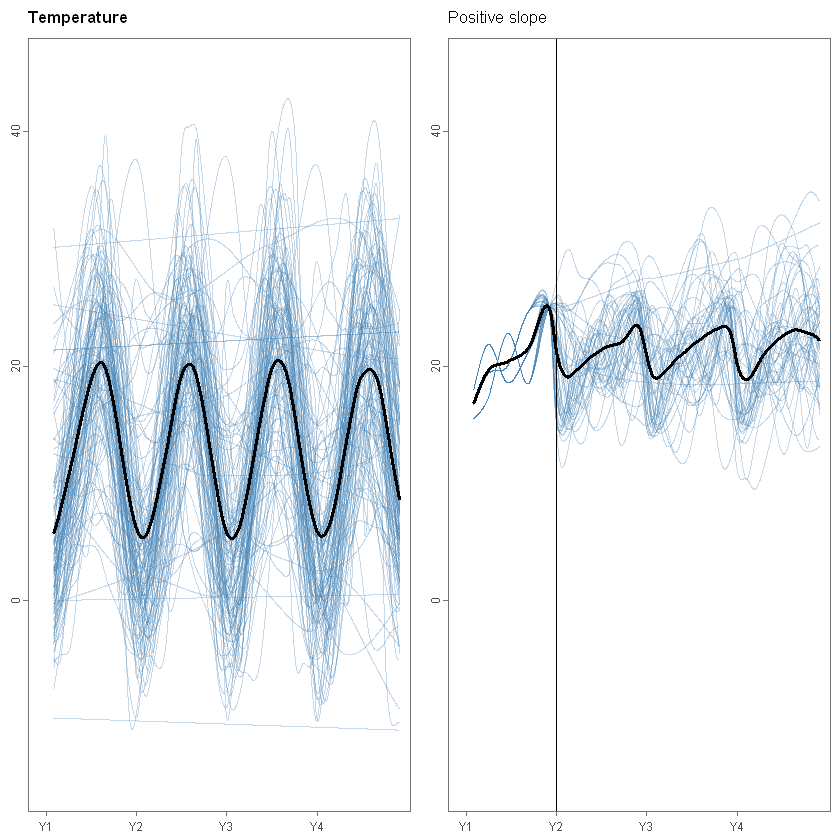

In [358]:
multiplot(plotlist=plots[1:2], layout=matrix(1:2, ncol=2, byrow=TRUE))

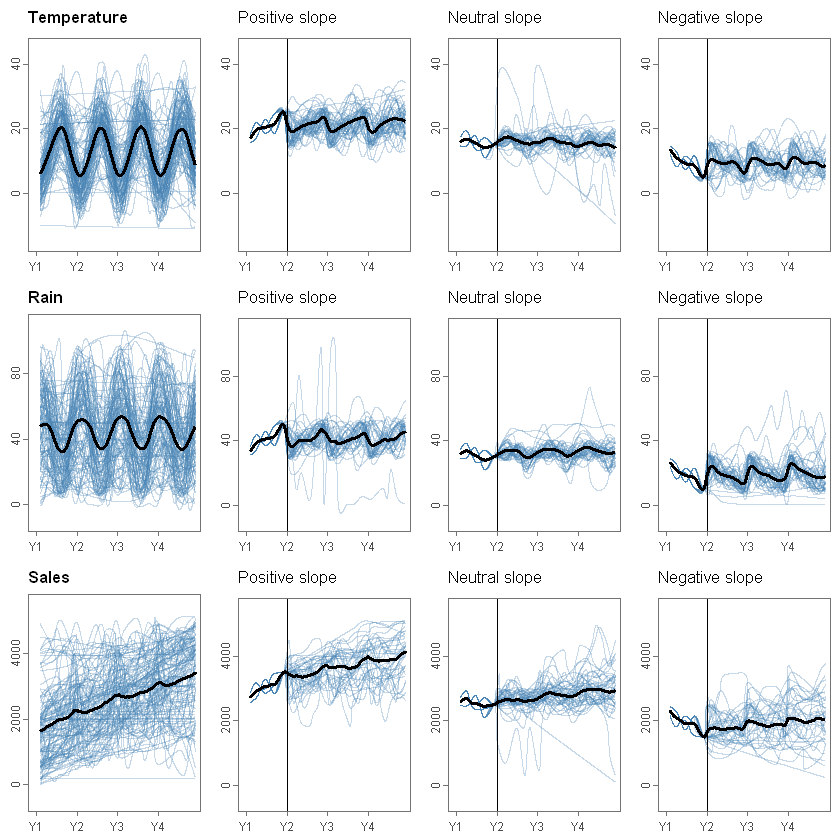

In [359]:
multiplot(plotlist=plots[1:12], layout=matrix(1:12, ncol=4, byrow=TRUE))

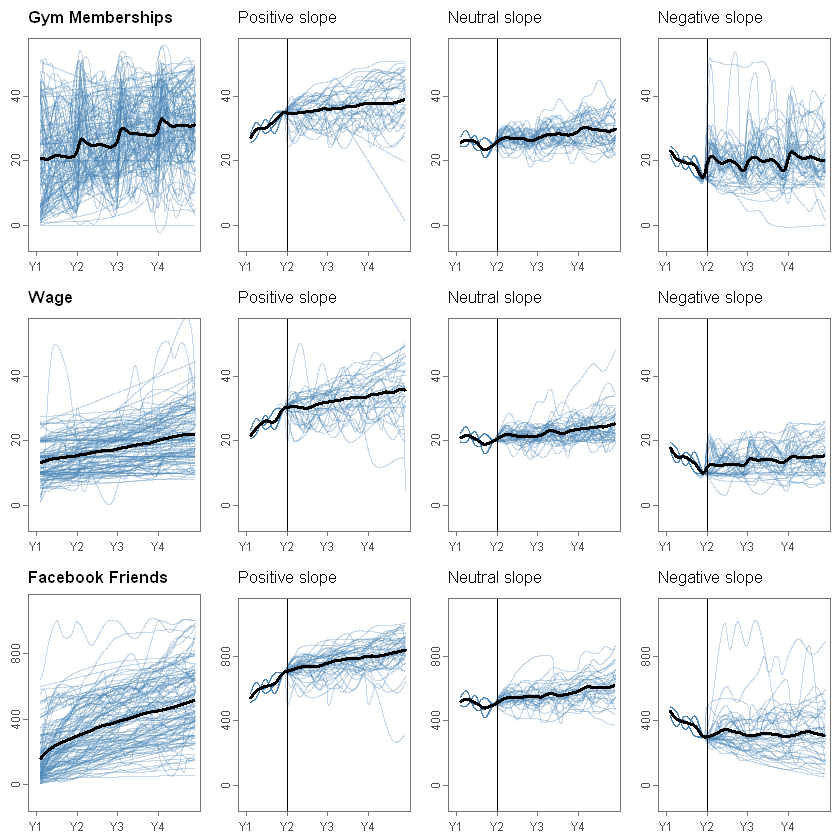

In [360]:
multiplot(plotlist=plots[13:24], layout=matrix(1:12, ncol=4, byrow=TRUE))